In [1]:
from collections import defaultdict
from collections.abc import Iterator
from random import shuffle
from itertools import product
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import time

In [2]:
class ExactCover(Iterator):
    """An iterator that yields solutions to an EXACT COVER problem.

    An EXACT COVER problem consists of a set of "choices". Each choice
    satisfies one or more "constraints". Choices and constraints may
    be represented by any hashable Python objects, with the proviso
    that all choices must be distinct, as must all constraints.

    A solution is a list of choices such that each constraint is
    satisfied by exactly one of the choices in the solution.

    """
    # This implements Donald Knuth's "Algorithm X"
    # http://lanl.arxiv.org/pdf/cs/0011047.pdf

    def __init__(self, constraints, initial=(), random=False):
        """Construct an ExactCover solver,

        Required argument:
        constraints -- A map from each choice to an iterable of
            constraints satisfied by that choice.

        Optional arguments:
        initial -- An iterable of choices that must appear in every
            solution. (Default: no choices.)
        random -- Generate solutions in random order? (Default: False.)

        For example:

            >>> next(ExactCover(dict(A = [1, 4, 7],
            ...                      B = [1, 4],
            ...                      C = [4, 5, 7],
            ...                      D = [3, 5, 6],
            ...                      E = [2, 3, 6, 7],
            ...                      F = [2, 7])))
            ['B', 'D', 'F']

        """
        self.random = random
        self.constraints = constraints

        # A map from constraint to the set of choices that satisfy
        # that constraint.
        self.choices = defaultdict(set)
        for i in self.constraints:
            for j in self.constraints[i]:
                self.choices[j].add(i)

        # The set of constraints which are currently unsatisfied.
        self.unsatisfied = set(self.choices)

        # The partial solution currently under consideration,
        # implemented as a stack of choices.
        self.solution = []

        # Make all the initial choices.
        try:
            for i in initial:
                self._choose(i)
            self.iter = self._solve()
        except KeyError:
            # Initial choices were contradictory, so there are no solutions.
            self.iter = iter(())

    def __next__(self):
        return next(self.iter)

    def _solve(self):
        if not self.unsatisfied:
            # No remaining unsatisfied constraints.
            yield list(self.solution)
            return

        # Pick the constraint with the fewest remaining choices
        # (Knuth's "S heuristic").
        best = min(self.unsatisfied, key=lambda j:len(self.choices[j]))
        choices = list(self.choices[best])
        if self.random:
            shuffle(choices)

        # Try each choice in turn and recurse.
        for i in choices:
            self._choose(i)
            yield from self._solve()
            self._unchoose(i)

    def _choose(self, i):
        """Make choice i; mark constraints satisfied; and remove any
        choices that clash with it.

        """
        self.solution.append(i)
        for j in self.constraints[i]:
            self.unsatisfied.remove(j)
            for k in self.choices[j]:
                for l in self.constraints[k]:
                    if l != j:
                        self.choices[l].remove(k)

    def _unchoose(self, i):
        """Unmake choice i; restore constraints and choices."""
        last = self.solution.pop()
        assert i == last
        for j in self.constraints[i]:
            self.unsatisfied.add(j)
            for k in self.choices[j]:
                for l in self.constraints[k]:
                    if l != j:
                        self.choices[l].add(k)

TETROMINOES = '''
IIII  LLL  OO  TTT  ZZ
      L    OO   T    ZZ
'''

PENTOMINOES = '''
I
I     L      N                      Y
I  FF L  PP  N TTT       V   W  X  YY ZZ
I FF  L  PP NN  T  U U   V  WW XXX  Y  Z
I  F  LL P  N   T  UUU VVV WW   X   Y  ZZ
'''


_EMPTY = ' '

def encode_polyominoes(picture):
    """Given a "picture" of some polyominoes (in ASCII-art form), return a
    list of tuples (name, tiles) for each polyomino, where tiles are
    the coordinates (i, j) of its tiles.

    >>> sorted(encode_polyominoes(TETROMINOES))
    ... # doctest: +NORMALIZE_WHITESPACE
    [('I', ((1, 0), (1, 1), (1, 2), (1, 3))),
     ('L', ((1, 6), (1, 7), (1, 8), (2, 6))),
     ('O', ((1, 11), (1, 12), (2, 11), (2, 12))),
     ('T', ((1, 15), (1, 16), (1, 17), (2, 16))),
     ('Z', ((1, 20), (1, 21), (2, 21), (2, 22)))]

    """
    pieces = defaultdict(list)
    for i, row in enumerate(picture.split('\n')):
        for j, c in enumerate(row):
            if c != _EMPTY:
                pieces[c].append((i, j))
    return [(c, tuple(tiles)) for c, tiles in pieces.items()]

def solution_tiles(solution):
    """Generate all the tiles in a polyomino solution."""
    return (t for _, tiles in solution for t in tiles)

def solution_bounds(solution):
    """Return the bounds of the region covered by a polyomino solution."""
    h, w = map(max, zip(*solution_tiles(solution)))
    return h + 1, w + 1

def decode_solution(solution):
    """Format a polyomino solution as a string."""
    h, w = solution_bounds(solution)
    grid = [[_EMPTY] * w for _ in range(h)]
    for c, tiles in solution:
        for i, j in tiles:
            grid[i][j] = c
    return grid



def polyomino(pieces, region, random=False):
    """Return an iterator that yields the solutions to a polyomino tiling
    problem.

    Required arguments:
    pieces -- an iterable of pieces, each being a tuple whose first
        element is the name of the piece and whose second element is a
        sequence of coordinates of the tiles in the piece (in an
        arbitrary coordinate system).
    region -- the region to fill (an iterable of coordinates x, y).

    Optional argument:
    random -- Generate solutions in random order? (Default: False.)

    >>> region = set(product(range(3), range(7))) - {(1, 2)}
    >>> sol = min(polyomino(encode_polyominoes(TETROMINOES), region))
    >>> print(decode_solution(sol))
    OOTTTZZ
    OO TZZL
    IIIILLL

    """
    region = list(region)
    region_set = set(region)
    constraints = {}
    for c, tiles in pieces:
        # Origin of piece at the first tile.
        oi, oj = tiles[0]
        # Adjust tiles so that they are relative to the origin of the piece.
        tiles = [(ti - oi, tj - oj) for ti, tj in tiles]
        for (oi, oj), ri, rj, rk in product(region, (-1, +1), (-1, +1), (0, 1)):
            # Place origin of piece at oi, oj, reflecting vertically
            # if ri == -1, horizontally if rj == -1, and diagonally if
            # rk == 1.
            placing = []
            for t in tiles:
                p = ri * t[rk] + oi, rj * t[1-rk] + oj
                if p not in region_set:
                    break
                placing.append(p)
            else:
                placing = tuple(sorted(placing))
                choice = c, placing
                if choice not in constraints:
                    constraints[choice] = (c,) + placing
    return ExactCover(constraints=constraints, random=random)

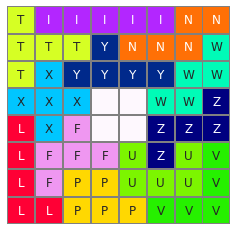

Solution took 0.3670 seconds


In [4]:
N =8
start = time.time()
region = set(product(range(N), repeat=2)) - set(product((3, 4), repeat=2))
solution = next(polyomino(encode_polyominoes(PENTOMINOES), region))
x =decode_solution(solution)

fig,ax = plt.subplots(1,1,figsize=(N/2,N/2)) 
shapes = [' ','F', 'I', 'L', 'N', 'P', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
mapping = np.vectorize(lambda x:shapes.index(x))
shading = mapping(x)
sns.heatmap(shading,annot=x,cbar=False,cmap="gist_ncar_r",fmt="",linewidths=1,linecolor="grey",annot_kws={"size":12},vmin=0,vmax=12)
ax.axis("off")
plt.show()
print('Solution took {:0.4f} seconds'.format(time.time()-start))